In [ ]:
# upload file to colab
from google.colab import files
uploaded = files.upload()

Saving chatgpt_reviews - chatgpt_reviews.csv to chatgpt_reviews - chatgpt_reviews.csv


In [ ]:
!pip -q install nltk scikit-learn imbalanced-learn plotly wordcloud textblob
!pip -q install tqdm joblib deep_translator unidecode
!pip install -q condacolab
import condacolab
condacolab.install()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 9.4 MB/s eta 0:00:00
⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:19
🔁 Restarting kernel...


In [ ]:
import warnings, os, pickle, json, re, textwrap, datetime as dt
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, plotly.express as px
from wordcloud import WordCloud
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve, auc)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

warnings.filterwarnings('ignore')

RANDOM_STATE = 42
pd.set_option('display.max_colwidth', 140)

DATA_PATH = "/content/chatgpt_reviews - chatgpt_reviews.csv"
REPORTS_DIR = "reports"
os.makedirs(REPORTS_DIR, exist_ok=True)

In [ ]:
# pip install tqdm joblib  (once)

from joblib import Parallel, delayed
from tqdm.auto import tqdm
import os, re, unicodedata, pandas as pd, nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.utils import resample

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

class DataPreprocessor:
    """
    Fast English‑only cleaner with both non‑balanced (`clean_df`)
    and balanced (`balanced_df`) outputs.
    """

    def __init__(self, data_path: str,
                 drop_non_english: bool = False,
                 n_jobs: int = os.cpu_count()):
        self.data_path   = data_path
        self.drop_non_en = drop_non_english
        self.n_jobs      = n_jobs
        self.wnl         = WordNetLemmatizer()
        self.stopset     = set(stopwords.words("english"))
        # outputs
        self.clean_df    = None   # full cleaned data
        self.balanced_df = None   # class‑balanced subset

    # ── helpers ────────────────────────────────────────────────────── #
    def _normalise(self, txt: str) -> str:
        txt = unicodedata.normalize("NFKD", txt).lower()
        return re.sub(r'[^a-z\s]', ' ', txt)        # keep only letters & space

    def _clean_one(self, text: str) -> str:
        if not isinstance(text, str):
            return ""
        tokens = word_tokenize(self._normalise(text))
        return " ".join(self.wnl.lemmatize(t) for t in tokens if t not in self.stopset)

    def _process_row(self, row):
        text = f"{row['title']} {row['review']}"
        cleaned   = self._clean_one(text)
        rating    = row['rating']
        sentiment = 'positive' if rating >= 4 else ('negative' if rating <= 2 else 'neutral')
        return cleaned, sentiment

    # ── public API ─────────────────────────────────────────────────── #
    def load_and_preprocess(self):
        df = pd.read_csv(self.data_path).dropna(subset=['review', 'rating'])
        if self.drop_non_en and 'language' in df.columns:
            df = df[df['language'].str.startswith('en', na=False)]

        # parallel cleaning
        rows = df[['title', 'review', 'rating']].to_dict(orient='records')
        # cleaned, sentiments = zip(*Parallel(n_jobs=self.n_jobs)(
        #     delayed(self._process_row)(r) for r in tqdm(rows, desc="🧹 Cleaning")
        # ))
        # non joblib
        cleaned, sentiments = zip(*map(self._process_row, tqdm(rows, desc="🧹 Cleaning")))


        df['cleaned_review']  = cleaned
        df['sentiment']       = sentiments
        df['sentiment_label'] = pd.Categorical(df['sentiment'],
                                               categories=['negative','neutral','positive']).codes
        self.clean_df = df

        # build balanced version
        min_size = df['sentiment'].value_counts().min()
        self.balanced_df = (pd.concat([resample(g, n_samples=min_size,
                                                replace=False, random_state=42)
                                       for _, g in df.groupby('sentiment')])
                            .sample(frac=1, random_state=42)
                            .reset_index(drop=True))

        print("✔ Cleaned rows:", len(self.clean_df),
              "| Balanced rows:", len(self.balanced_df))
        return self.clean_df, self.balanced_df

    # (optional) re‑use the splitter from before on either DataFrame…
    def split_data(self, df, test_size=0.2, val_size=0.1, random_state=42):
        from sklearn.model_selection import train_test_split
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            df['cleaned_review'], df['sentiment_label'],
            test_size=test_size, stratify=df['sentiment_label'],
            random_state=random_state
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val,
            test_size=val_size / (1 - test_size),
            stratify=y_train_val, random_state=random_state
        )
        return X_train, X_val, X_test, y_train, y_val, y_test


In [ ]:
prep = DataPreprocessor("chatgpt_reviews - chatgpt_reviews.csv",
                        drop_non_english=False,   # keep all languages
                        n_jobs=8)                 # or any CPU count
clean_df, balanced_df = prep.load_and_preprocess()

print("\nSentiment counts (full):\n", clean_df['sentiment'].value_counts())
print("\nSentiment counts (balanced):\n", balanced_df['sentiment'].value_counts())

# modelling on balanced set
X_tr, X_val, X_te, y_tr, y_val, y_te = prep.split_data(balanced_df)


🧹 Cleaning:   0%|          | 0/10000 [00:00<?, ?it/s]

✔ Cleaned rows: 10000 | Balanced rows: 5829

Sentiment counts (full):
 sentiment
negative    4069
positive    3988
neutral     1943
Name: count, dtype: int64

Sentiment counts (balanced):
 sentiment
positive    1943
negative    1943
neutral     1943
Name: count, dtype: int64


In [ ]:
clean_df.head(1)

,date,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase,cleaned_review,sentiment,sentiment_label
0,2/15/2025,Impressive,Mother former community upon vote fact. Sure stock rich could soldier PM wear.,2,ybass,68,78,Mobile,es,Canada,3.0,No,impressive mother former community upon vote fact sure stock rich could soldier pm wear,negative,0


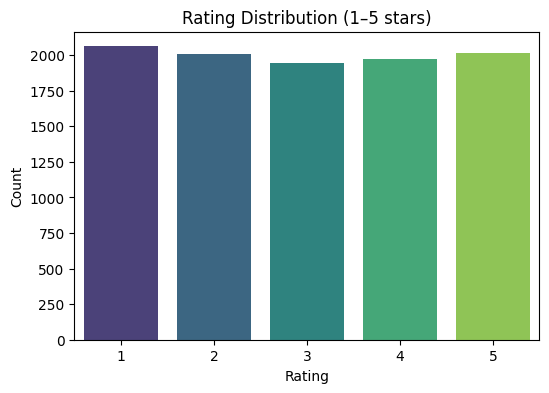

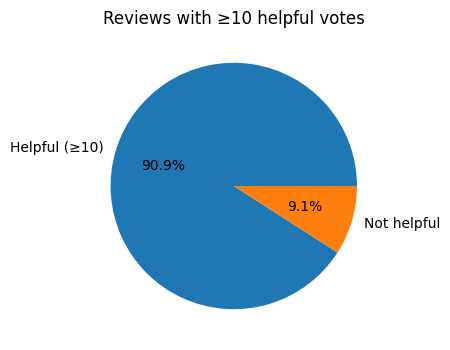

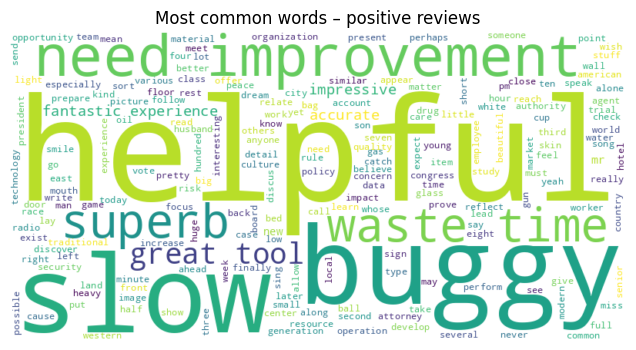

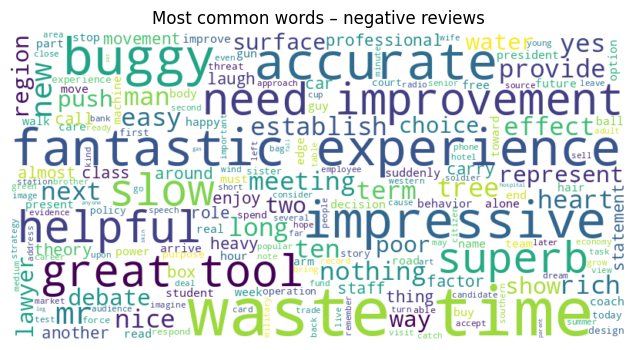

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [ ]:
#!pip install -U kaleido
# %% [code] Q1 Distribution of review ratings
rating_counts = clean_df['rating'].value_counts().sort_index()
plt.figure(figsize=(6,4))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')
plt.title("Rating Distribution (1–5 stars)"); plt.xlabel("Rating"); plt.ylabel("Count")
plt.savefig(f"{REPORTS_DIR}/rating_distribution.png"); plt.show()

# %% [code] Q2 Helpful votes above threshold (≥10)
helpful = clean_df['helpful_votes'].fillna(0)
threshold = 10
counts = pd.Series({'Helpful (≥10)': (helpful>=threshold).sum(),
                    'Not helpful'   : (helpful<threshold).sum()})
counts.plot(kind='pie', autopct='%1.1f%%', figsize=(4,4), title="Reviews with ≥10 helpful votes")
plt.ylabel('')
plt.savefig(f"{REPORTS_DIR}/helpful_votes_pie.png"); plt.show()

# %% [code] Q3 Word clouds for positive vs negative
pos_text = " ".join(clean_df.loc[clean_df['rating']>=4, 'cleaned_review'])
neg_text = " ".join(clean_df.loc[clean_df['rating']<=2, 'cleaned_review'])
for label, text in [('positive', pos_text), ('negative', neg_text)]:
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    wc.to_file(f"{REPORTS_DIR}/wc_{label}.png")
    plt.figure(figsize=(10,4)); plt.imshow(wc, interpolation='bilinear'); plt.axis('off')
    plt.title(f"Most common words – {label} reviews")
    plt.show()

# %% [code] Q4 Average rating over time (monthly)
clean_df['date'] = pd.to_datetime(clean_df['date'], errors='coerce')
monthly = clean_df.groupby(pd.Grouper(key='date', freq='M'))['rating'].mean().reset_index()
fig = px.line(monthly, x='date', y='rating', title='Average Rating Over Time')
fig.write_image(f"{REPORTS_DIR}/rating_over_time.png"); fig.show()

# %% [code] Q5 Ratings by location (top 10)
top_loc = clean_df['location'].value_counts().head(10).index
loc_df = clean_df[clean_df['location'].isin(top_loc)].groupby('location')['rating'].mean().sort_values()
loc_df.plot(kind='barh', figsize=(6,4), title='Avg Rating by Location (Top 10)')
plt.xlabel('Average Rating'); plt.tight_layout(); plt.savefig(f"{REPORTS_DIR}/rating_by_location.png"); plt.show()

# %% [code] Q6 Web vs Mobile ratings
sns.barplot(data=clean_df, x='platform', y='rating', palette='Set2')
plt.title("Average Rating by Platform"); plt.savefig(f"{REPORTS_DIR}/platform_rating.png"); plt.show()

# %% [code] Q7 Verified vs Non‑verified ratings
vr = clean_df.groupby('verified_purchase')['rating'].mean()
sns.barplot(x=vr.index, y=vr.values)
plt.title("Average Rating – Verified vs Non‑verified"); plt.ylabel("Avg Rating")
plt.savefig(f"{REPORTS_DIR}/verified_rating.png"); plt.show()

# %% [code] Q8 Avg review length per rating bucket
clean_df['review_length'] = clean_df['review'].str.len()
sns.boxplot(data=clean_df, x='rating', y='review_length')
plt.title("Review Length vs Rating"); plt.savefig(f"{REPORTS_DIR}/length_vs_rating.png"); plt.show()

# %% [code] Q9 Top words in 1‑star reviews
from collections import Counter
one_star_tokens = [tok for text in clean_df.loc[clean_df['rating']==1,'cleaned_review']
                   for tok in text.split()]
top20 = Counter(one_star_tokens).most_common(20)
pd.DataFrame(top20, columns=['word','freq']).set_index('word').plot.bar(figsize=(8,4))
plt.title("Top 20 words in 1‑star reviews"); plt.savefig(f"{REPORTS_DIR}/top_words_one_star.png"); plt.show()

# %% [code] Q10 Which version has highest average rating?
ver = clean_df.groupby('version')['rating'].mean().sort_values(ascending=False)
ver.plot(kind='bar', figsize=(8,4))
plt.title("Average Rating by ChatGPT Version"); plt.ylabel("Avg Rating")
plt.savefig(f"{REPORTS_DIR}/rating_by_version.png"); plt.show()

In [ ]:
"""
Feature Extraction Module for ChatGPT Reviews Sentiment Analysis
----------------------------------------------------------------
Handles text vectorisation (Count / TF‑IDF), dimensionality reduction (SVD),
and generation of additional numeric text features.
"""
!pip install -q vaderSentiment textstat
# ── standard libs ───────────────────────────────────────────────────────
import re, os, numpy as np, pandas as pd
from typing import List, Tuple

# ── sklearn / scipy ─────────────────────────────────────────────────────
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack, csr_matrix
import joblib

# ── extra feature libs ──────────────────────────────────────────────────
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import textstat, nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt', quiet=True)

# ════════════════════════════════════════════════════════════════════════
# 1.  ExtraTextFeatures  (cheap numeric cues)
# ════════════════════════════════════════════════════════════════════════
class ExtraTextFeatures:
    """Compute hand‑crafted numeric features from a cleaned text string."""
    punct_re = re.compile(r'[!?…]')
    emoji_re = re.compile(r'[\U0001F600-\U0001F64F]', flags=re.UNICODE)

    def __init__(self) -> None:
        self.vader = SentimentIntensityAnalyzer()

    # ----- per‑row helper ------------------------------------------------
    def _row_stats(self, txt: str) -> List[float]:
        if not isinstance(txt, str): txt = ""
        words = txt.split()
        sents = re.split(r'[.!?]+', txt)

        n_char = len(txt)
        n_word = len(words)            or 1
        n_sent = len([s for s in sents if s.strip()]) or 1
        avgw   = np.mean([len(w) for w in words]) if words else 0
        caps   = sum(c.isupper() for c in txt) / n_char if n_char else 0
        punct  = len(self.punct_re.findall(txt))
        emoji  = len(self.emoji_re.findall(txt))
        types  = len(set(words))
        ttr    = types / n_word                    # type–token ratio
        hapax  = sum(1 for w in set(words) if words.count(w) == 1) / n_word
        vader  = self.vader.polarity_scores(txt)   # dict keys: pos / neu / neg / compound
        grade  = textstat.flesch_kincaid_grade(txt) if n_word > 20 else 0

        return [
            n_char, n_word, n_sent, avgw, caps,
            punct, emoji, ttr, hapax, grade,
            vader['pos'], vader['neu'], vader['neg'], vader['compound']
        ]

    # ----- public --------------------------------------------------------
    def transform(self, series: pd.Series) -> np.ndarray:
        """Return (n_samples, 14) float32 array of extra features."""
        mat = np.vstack([self._row_stats(t) for t in series])
        return mat.astype('float32')

    @property
    def feature_names(self) -> List[str]:
        return [
            'char_cnt', 'word_cnt', 'sent_cnt', 'avg_word_len', 'caps_ratio',
            'punct_cnt', 'emoji_cnt', 'type_token_ratio', 'hapax_ratio',
            'fk_grade', 'v_pos', 'v_neu', 'v_neg', 'v_compound'
        ]

# ════════════════════════════════════════════════════════════════════════
# 2.  Main FeatureExtractor
# ════════════════════════════════════════════════════════════════════════
class FeatureExtractor:
    """
    Text‑feature pipeline:
      * Bag‑of‑words (Count)  – optional
      * TF‑IDF (default)
      * Optional SVD reduction
      * Extra numeric features (length, VADER, readability, etc.)
    """

    # ------------------------------------------------------------------ #
    def __init__(self,
                 max_features: int = 5000,
                 ngram_range: Tuple[int, int] = (1, 2),
                 svd_components: int = 300):
        self.max_features = max_features
        self.ngram_range  = ngram_range
        self.svd_components = svd_components

        # vectorisers
        self.count_vectorizer = CountVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            min_df=2
        )
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            min_df=2,
            use_idf=True,
            smooth_idf=True,
            sublinear_tf=True
        )
        self.svd = TruncatedSVD(n_components=svd_components, random_state=42)

        # extra features
        self.extra = ExtraTextFeatures()

        # fitted flags
        self.is_fitted = {'count': False, 'tfidf': False, 'svd': False}

    # ═══ Vectoriser helpers ═══════════════════════════════════════════ #
    def fit_count(self, X_train):
        X = self.count_vectorizer.fit_transform(X_train)
        self.is_fitted['count'] = True
        print(f"CountVectorizer fitted → shape {X.shape}")
        return X

    def transform_count(self, X):
        if not self.is_fitted['count']:
            raise RuntimeError("CountVectorizer not fitted.")
        return self.count_vectorizer.transform(X)

    def fit_tfidf(self, X_train):
        X = self.tfidf_vectorizer.fit_transform(X_train)
        self.is_fitted['tfidf'] = True
        print(f"TF‑IDF fitted → shape {X.shape}")
        return X

    def transform_tfidf(self, X):
        if not self.is_fitted['tfidf']:
            raise RuntimeError("TF‑IDF not fitted.")
        return self.tfidf_vectorizer.transform(X)

    # ═══ SVD helpers ═══════════════════════════════════════════════════ #
    def fit_svd(self, X_tfidf):
        X_red = self.svd.fit_transform(X_tfidf)
        self.is_fitted['svd'] = True
        evr = self.svd.explained_variance_ratio_.sum()
        print(f"SVD fitted → reduced to {X_red.shape[1]} dims | EVR={evr:.3f}")
        return X_red

    def transform_svd(self, X_tfidf):
        if not self.is_fitted['svd']:
            raise RuntimeError("SVD not fitted.")
        return self.svd.transform(X_tfidf)

    # ═══ Extra numeric features + combiner ═════════════════════════════ #
    def extras(self, text_series: pd.Series) -> csr_matrix:
        dense = self.extra.transform(text_series)          # (n, 14)
        return csr_matrix(dense)                           # keep sparse pipeline happy

    def combine(self, sparse_mat, text_series) -> csr_matrix:
        """Concatenate sparse BoW/SVD with dense extras (returns CSR)."""
        return hstack([sparse_mat, self.extras(text_series)], format='csr')

    # ═══ Top‑feature helper (for inspection) ═══════════════════════════ #
    def get_top_tfidf(self, n=20) -> List[Tuple[str, float]]:
        if not self.is_fitted['tfidf']:
            raise RuntimeError("TF‑IDF not fitted.")
        names = self.tfidf_vectorizer.get_feature_names_out()
        # compute global importance
        dummy = " ".join(names)
        vec   = self.tfidf_vectorizer.transform([dummy])
        scores = np.asarray(vec.sum(axis=0)).ravel()
        idx = scores.argsort()[::-1][:n]
        return [(names[i], scores[i]) for i in idx]

    # ═══ Persistence helpers ═══════════════════════════════════════════ #
    def save(self, path_prefix: str = '../models/'):
        os.makedirs(path_prefix, exist_ok=True)
        if self.is_fitted['count']:
            joblib.dump(self.count_vectorizer, f"{path_prefix}count_vec.joblib")
        if self.is_fitted['tfidf']:
            joblib.dump(self.tfidf_vectorizer, f"{path_prefix}tfidf_vec.joblib")
        if self.is_fitted['svd']:
            joblib.dump(self.svd,              f"{path_prefix}svd.joblib")
        print("✔ Vectorisers/SVD saved to", path_prefix)

    @classmethod
    def load(cls, path_prefix: str = '../models/'):
        inst = cls()
        try:
            inst.count_vectorizer = joblib.load(f"{path_prefix}count_vec.joblib")
            inst.is_fitted['count'] = True
        except FileNotFoundError:
            pass
        try:
            inst.tfidf_vectorizer = joblib.load(f"{path_prefix}tfidf_vec.joblib")
            inst.is_fitted['tfidf'] = True
        except FileNotFoundError:
            pass
        try:
            inst.svd = joblib.load(f"{path_prefix}svd.joblib")
            inst.is_fitted['svd'] = True
        except FileNotFoundError:
            pass
        return inst


import pickle
# X_tr, X_val, X_te, y_tr, y_val, y_te



X_train = X_tr
X_val   = X_val
X_test  = X_te

fe = FeatureExtractor(max_features=5000)

# ----- TF‑IDF branch ------------------------------------------------
X_tr_tf = fe.fit_tfidf(X_train)
X_val_tf = fe.transform_tfidf(X_val)
X_te_tf  = fe.transform_tfidf(X_test)

# ----- Optionally reduce dims (SVD) --------------------------------
X_tr_red = fe.fit_svd(X_tr_tf)
X_val_red = fe.transform_svd(X_val_tf)
X_te_red  = fe.transform_svd(X_te_tf)

# ----- Add extra numeric features ---------------------------------
X_tr_full = fe.combine(X_tr_tf,  X_train)
X_val_full = fe.combine(X_val_tf, X_val)
X_te_full  = fe.combine(X_te_tf,  X_test)

# Save artefacts
fe.save()

# Persist vectorised splits for modelling
vectorised = {
    'X_train_full': X_tr_full, 'X_val_full': X_val_full, 'X_test_full': X_te_full,
    'y_train': y_tr, 'y_val': y_val, 'y_test': y_te
}
# with open('../data/vectorised_full.pkl', 'wb') as f:
#     pickle.dump(vectorised, f)

print("Top TF‑IDF features:", fe.get_top_tfidf(10))



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 78.4 MB/s eta 0:00:00
TF‑IDF fitted → shape (4080, 5000)
SVD fitted → reduced to 300 dims | EVR=0.432
✔ Vectorisers/SVD saved to ../models/
Top TF‑IDF features: [('mr', np.float64(0.027676182408522623)), ('kid', np.float64(0.026817757545744062)), ('agency', np.float64(0.02666654564047451)), ('happy', np.float64(0.026337529116529958)), ('often', np.float64(0.02606294589376046)), ('determine', np.float64(0.026059621703602848)), ('south', np.float64(0.025984293679991256)), ('mission', np.float64(0.02592072339499059)), ('choice', np.float64(0.02589973782406222)), ('thank', np.float64(0.0258805851333221))]


In [ ]:
# =============================================
# 0 · Imports & data
# =============================================
import os, pickle, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from scipy.sparse import vstack
import joblib, warnings; warnings.filterwarnings("ignore")

RANDOM_STATE = 42
REPORTS_DIR  = "reports"; os.makedirs(REPORTS_DIR, exist_ok=True)
MODEL_DIR    = "models";  os.makedirs(MODEL_DIR,   exist_ok=True)

# ---------- load vectorised matrices (produced earlier) -------------

X_train = vectorised["X_train_full"]; y_train = vectorised["y_train"]
X_val   = vectorised["X_val_full"];   y_val   = vectorised["y_val"]
X_test  = vectorised["X_test_full"];  y_test  = vectorised["y_test"]

# =============================================
# 1 · Helper functions
# =============================================
def macro_auc_ovr(model, X, y):
    """Macro‑average OvR ROC‑AUC (works if predict_proba available)."""
    if not hasattr(model, "predict_proba"): return np.nan
    proba = model.predict_proba(X)
    return np.mean([roc_auc_score((y==c).astype(int), proba[:,i])
                    for i,c in enumerate(model.classes_)])

def eval_and_log(name, clf, X, y):
    pred = clf.predict(X)
    res  = dict(
        model=name,
        acc = accuracy_score(y, pred),
        prec= precision_score(y, pred, average="macro"),
        rec = recall_score(y, pred, average="macro"),
        f1  = f1_score(y, pred, average="macro"),
        roc_auc = macro_auc_ovr(clf, X, y)
    )
    return res

def plot_cm(clf, X, y, title):
    cm = confusion_matrix(y, clf.predict(X), labels=[0,1,2])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['pos','neu','neg'],
                yticklabels=['pos','neu','neg'])
    plt.title(title); plt.ylabel("True"); plt.xlabel("Pred")
    plt.tight_layout()
    plt.savefig(f"{REPORTS_DIR}/cm_{title.replace(' ','_')}.png"); plt.close()

# =============================================
# 2 · Training & tuning
# =============================================
class SimpleTrainer:
    def __init__(self):
        self.models, self.scores = {}, {}
        self.best_name = None; self.best_model = None; self.best_f1 = 0

    # ---- generic train wrapper ----------------
    def _train(self, name, estimator, param_grid=None, randomized=False,
               X_tr=None, y_tr=None, X_val=None, y_val=None, needs_dense=False):
        print(f"\n🔧  Training {name} ...")
        t0 = time()
        X_tr_, X_val_ = (X_tr.toarray(), X_val.toarray()) if needs_dense else (X_tr, X_val)

        if param_grid:
            # Pass n_iter only to RandomizedSearchCV

            if randomized:
                search_params = {
                    'estimator': estimator,
                    'param_distributions': param_grid,
                    'cv': 3,
                    'scoring': 'f1_macro',
                    'n_jobs': -1,
                }
                search_params['n_iter'] = 10
                search = RandomizedSearchCV(**search_params)
            else:
                search_params = {
                    'estimator': estimator,
                    'param_grid': param_grid,
                    'cv': 3,
                    'scoring': 'f1_macro',
                    'n_jobs': -1,
                }
                search = GridSearchCV(**search_params)
            search.fit(X_tr_, y_tr); clf = search.best_estimator_
            print("  ↳ best params:", search.best_params_)
        else:
            clf = estimator.fit(X_tr_, y_tr)

        sec = time()-t0; print(f"  ↳ done in {sec:.1f}s")

        # store model & validation score
        val_res = eval_and_log(name, clf, X_val_, y_val)
        self.models[name] = clf; self.scores[name] = val_res['f1']
        print(f"  ↳ Val F1 = {val_res['f1']:.3f}")

        if val_res['f1'] > self.best_f1:
            self.best_f1 = val_res['f1']; self.best_name = name; self.best_model = clf
        return clf

    # ---- specific models ----------------------
    def logreg(self, *args, **kw):
        weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        cw = {i:w for i,w in enumerate(weights)}
        est = LogisticRegression(max_iter=2500, class_weight=cw, n_jobs=-1, multi_class="ovr")
        grid = {'C':[0.1,1,5,10]}
        return self._train("LogReg", est, grid, False, *args, **kw)

    def mnb(self, *args, **kw):
        return self._train("MultinomialNB", MultinomialNB(), None, False, *args, **kw)

    def svm(self, *args, **kw):
        est = LinearSVC(class_weight='balanced', dual=False, random_state=RANDOM_STATE, max_iter=2500)
        grid = {'C':[0.1,1,5,10]}
        return self._train("LinearSVC", est, grid, False, *args, **kw)

    def rf(self, *args, **kw):
        est = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
        grid = {'n_estimators':[200,400], 'max_depth':[None,20]}
        return self._train("RandomForest", est, grid, True, needs_dense=True, *args, **kw)

    def xgb(self, *args, **kw):
        est = XGBClassifier(objective='multi:softprob', num_class=3, eval_metric='mlogloss',
                            random_state=RANDOM_STATE)
        grid = {'n_estimators':[200,400], 'max_depth':[6,10], 'learning_rate':[0.05,0.1]}
        return self._train("XGBoost", est, grid, True, needs_dense=True, *args, **kw)

    # ---- save / plot --------------------------
    def finalise(self, X_test):
        print(f"\n🏆  Best model on val: {self.best_name} (F1={self.best_f1:.3f})")
        dense_needed = self.best_name in ["RandomForest","XGBoost"]
        X_te_ = X_test.toarray() if dense_needed else X_test
        test_res = eval_and_log(self.best_name, self.best_model, X_te_, y_test)
        plot_cm(self.best_model, X_te_, y_test, self.best_name+"_test")
        pd.DataFrame({**test_res, **{'best_val_f1':self.best_f1}}, index=[0]).to_csv(
            f"{REPORTS_DIR}/best_model_metrics.csv", index=False)
        joblib.dump(self.best_model, f"{MODEL_DIR}/{self.best_name}_model.joblib")
        print("✔  saved best model & metrics")

# =============================================
# 3 · Run the training suite
# =============================================
trainer = SimpleTrainer()

trainer.logreg(X_tr=X_train, y_tr=y_train, X_val=X_val, y_val=y_val)
# trainer.mnb   (X_tr=X_train, y_tr=y_train, X_val=X_val, y_val=y_val)
trainer.svm   (X_tr=X_train, y_tr=y_train, X_val=X_val, y_val=y_val)
trainer.rf    (X_tr=X_train, y_tr=y_train, X_val=X_val, y_val=y_val)
trainer.xgb   (X_tr=X_train, y_tr=y_train, X_val=X_val, y_val=y_val)

trainer.finalise(X_test)



🔧  Training LogReg ...
  ↳ best params: {'C': 1}
  ↳ done in 61.6s
  ↳ Val F1 = 0.314

🔧  Training LinearSVC ...
  ↳ best params: {'C': 0.1}
  ↳ done in 2.3s
  ↳ Val F1 = 0.309

🔧  Training RandomForest ...
  ↳ best params: {'n_estimators': 200, 'max_depth': None}
  ↳ done in 195.3s
  ↳ Val F1 = 0.322

🔧  Training XGBoost ...
  ↳ best params: {'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.1}
  ↳ done in 1269.4s
  ↳ Val F1 = 0.337

🏆  Best model on val: XGBoost (F1=0.337)
✔  saved best model & metrics


In [ ]:
# load the best model and compute the folllowiong:
# Project Evaluation Metrics
# ● Accuracy: Measures the correctness of sentiment classification.
# ● Precision & Recall: Ensures the reliability of positive and negative
# classifications.
# ● F1-Score: Balances precision and recall to evaluate model performance.
# ● Confusion Matrix: Visual representation of classification errors.
# ● AUC-ROC Curve: Measures the ability of the model to differentiate sentiment
# categories.

import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score

best_model = joblib.load(f"{MODEL_DIR}/XGBoost_model.joblib")

# Predict on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print("Confusion Matrix:")
print(confusion)

# auc curve
y_proba = best_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
print(f"AUC-ROC Curve: {roc_auc}")

# auc per categpry
roc_auc_per_category = roc_auc_score(y_test, y_proba, multi_class='ovr', average=None)
print("AUC-ROC Curve per Category:")
for i, category in enumerate(['positive', 'neutral', 'negative']):
    print(f"{category}: {roc_auc_per_category[i]}")

Accuracy: 0.3319039451114923
Precision: 0.11101549053356281
Recall: 0.33161953727506427
F1-Score: 0.16634429400386846
Confusion Matrix:
[[  0 388   0]
 [  2 387   0]
 [  2 387   0]]
AUC-ROC Curve: 0.4976112513579718
AUC-ROC Curve per Category:
positive: 0.5153744732727321
neutral: 0.5074126642250036
negative: 0.4700466165761795
